In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import lmfit
import matplotlib.pylab as pyl
import re
import imageio
import plotly.express as px

In [24]:
global colspecs_ardn, colspecs_profile
colspecs_ardn = [(0, 14), (15, 34), (35, 50)]
colspecs_profile = [(0, 13), (13, 26), (26, 35), (37, 43)]

In [148]:
def get_fluence_Yb(spectrumfile, calibrationinfo,incomingfluenceA2='notgiven'):
    fl_cal = calibrationinfo['fl_cal']
    int_cal = calibrationinfo['int_cal']
    char_cal = calibrationinfo['char_cal']
    with open(spectrumfile) as f:
        lines = f.readlines()
    #incomingfluenceA2 = int((lines[2])[23:-1])
    char_exp = float((lines[18])[20:len(lines[18])-1])
    RBS_data = np.array(pd.read_csv(spectrumfile, sep='\t',lineterminator='\n', skiprows=20))
    plt.figure(figsize = (20,10))
    plt.plot(RBS_data[:,0], RBS_data[:,1],'.')
    #plt.xlim(700,1000)
    plt.ylim(-100,1000)
    a=860
    b=920
    #plt.axvline(a)
    #plt.axvline(b)
    plt.plot(RBS_data[a:b,0],RBS_data[a:b,1],'.')
    plt.xlabel('Channel number')
    plt.ylabel('Number of counts')
    plt.grid()
    plt.savefig('Yborange.pdf')
    int_exp = np.sum(RBS_data[a:b,1])
    fluence_K = int_exp * (fl_cal/int_cal) * char_cal/char_exp
    print('For an incoming fluence = ' + str(incomingfluenceA2)+ 'A$^{-2}$, the amount that is retained on the foil equals ' +
         str(fluence_K)+ 'A$^{-2}$.')
    return fluence_K

In [115]:
plt.rcParams.update({'font.size': 40})

In [116]:
class TRIDYN_simulation:
    def __init__(self, file_retained = "", file_profiles = ""):
        self.file_retained = file_retained
        self.file_profiles = file_profiles
        self.fluence_vals = 0
        self.retained_vals = 0
        self.retained_calc = 0
        self.depth_vals = 0
        self.concentration_vals_implanted = 0
        self.concentration_vals_substrate = 0
        self.surface_density = 0
        
        
    def print_filenames(self):
        if (self.file_retained != ""):
            print("retained amount is located at " + self.file_retained + "\n")
        if (self.file_profiles != ""):
            print("Depth profiles is located at " + self.file_profiles + "\n")
            
            
    def load_retained(self):
        if (self.file_retained != ""):
            simulation = np.array(pd.read_fwf(self.file_retained, colspecs=colspecs_ardn, header=1).T)
            self.fluence_vals = simulation[0]
            self.retained_vals = simulation[2]
        else:
            print("No ardn file selected")
            self.fluence_vals = np.zeros(100)
            self.retained_vals = np.zeros(100)
      
    
    def load_profiles(self):
        if (self.file_profiles != ""):
            ls_files = os.listdir(path=self.file_profiles)
            
            self.depth_vals = []
            self.surface_density = []
            self.concentration_vals_substrate = []
            self.concentration_vals_implanted = []
            
            
            for i in range(len(ls_files)):
                directory_file = self.file_profiles + ls_files[i]
                
                single_profile = np.array(pd.read_fwf(directory_file, colspecs = colspecs_profile, header=4).T)
                
                for i in range(len(single_profile[2])):
                    single_profile[2][i] = np.float64(str(single_profile[2][i]).rstrip("-").lstrip("-"))
                    single_profile[3][i] = np.float64(str(single_profile[3][i]).rstrip("-").lstrip("-"))
                
                #print(single_profile[2])
                
                self.depth_vals.append(single_profile[0])
                self.surface_density.append(single_profile[1])
                self.concentration_vals_substrate.append(single_profile[2])
                self.concentration_vals_implanted.append(single_profile[3])
        
        else:
            print("No depth profile files selected")
            self.depth_vals = np.zeros((100, 100))
            self.surface_density = np.zeros((100, 100))
            self.concentration_vals_substrate = np.zeros((100, 100))
            self.concentration_vals_implanted = np.zeros((100, 100))
        
        
    def calc_retained(self, start_depth=0, end_depth=10**6):
        del_depth = self.depth_vals[0][1] - self.depth_vals[0][0]
        max_depth = self.depth_vals[0][-1] + del_depth/2
        self.retained_calc = np.zeros(len(self.retained_vals))
        
        for i in range(len(self.depth_vals)):            
            acc = 0
            
            for j in range(len(self.depth_vals[0])):    
                if ((self.depth_vals[0][j] > start_depth) and (self.depth_vals[0][j] < end_depth)):
                    acc += del_depth * self.concentration_vals_implanted[i][j] * self.surface_density[i][j]
            
            self.retained_calc[i] = acc        
        
        
    def load(self):
        self.load_retained()
        self.load_profiles()
        
        
    def draw_retained(self, **kwargs):
        plt.plot(self.fluence_vals, self.retained_vals)
        plt.xlabel("Implantation fluence ($\AA ^{-2}$)")
        plt.ylabel("Retained fluence ($\AA ^{-2}$)")
        plt.grid()
        
        
    def draw_lost(self, **kwargs):
        plt.plot(self.fluence_vals, self.fluence_vals - self.retained_vals)
        plt.xlabel("Implantation fluence ($\AA ^{-2}$)")
        plt.ylabel("Lost fluence ($\AA ^{-2}$)")
        plt.grid()
        
    
    def draw_calc_retained(self, **kwargs):
        plt.plot(self.fluence_vals, self.retained_calc, "--")
        plt.xlabel("Implantation fluence ($\AA ^{-2}$)")
        plt.ylabel("Retained fluence ($\AA ^{-2}$)")
        plt.grid()
        
        
    def draw_profile(self, index, bool_implant, **kwargs):
        if bool_implant:
            plt.plot(self.depth_vals[index], self.concentration_vals_implanted[index])

        else:
            plt.plot(self.depth_vals[index], self.concentration_vals_substrate[index])
        
        plt.xlabel("Depth ($\AA$)")
        plt.ylabel("Concentration (%)")
        plt.grid()
        
        
    def draw_3d(self, **kwargs):
        X = self.depth_vals[0]
        Y = self.fluence_vals
        Z = self.concentration_vals_implanted
        
        X, Y = np.meshgrid(X, Y)
        
        im = pyl.pcolormesh(X, Y, Z, shading='auto')
        cbar = plt.colorbar(im,orientation='vertical')
        plt.xlabel("Depth ($\AA$)")
        plt.ylabel("Fluence ($\AA ^{-2}$)")
        cbar.set_label("Atomic concentration (%)")

In [180]:
def get_info(energy, foilmat,lijnstijl, kleur, RBSfiles, calibrationinfo, incomingfluences,plotlim = 4, savenaam='bla', prelim=False):
    plt.rcParams.update({'font.size': 40})
    # create list of all 10 simulations that are performed for this isotope, foil and energy (10 times same simulation but different random seeds)
    ls_names = []
    for ii in range(10): 
        ls_names.append('ex'+ foilmat+'_'+ str(ii)+'_'+str(round(energy)).zfill(3))
        # extract the retained curves (10 such curves)
    retainedcurves = []
    for name in ls_names:
        path = "C:/Users/r0750853/linux/Experimentalconfirmation_Tridyn_Yb/simulated_data/"
        areal_dens = "Areal_density/" + name + "_ardn.dat"
        profiles = "Depth_profile/" + name + "/"
        A = TRIDYN_simulation(file_retained = path + areal_dens, file_profiles = path + profiles)
        A.load()
        retainedcurves.append(np.array(A.retained_vals))
    retainedcurves = np.array(retainedcurves)
    influ = A.fluence_vals
    # determination of the mean value and upper and lower limit for each of the incoming fluences
    means = []
    stdevup = []
    stdevdown = []
    for ii in range(101):
        retvalues = retainedcurves[:,ii]
        means.append(np.mean(retvalues))
        retvalues_sorted  = np.sort(retvalues)
        stdevdown.append(retvalues_sorted[1])
        stdevup.append(retvalues_sorted[7])
    means = np.array(means)
    stdevup = np.array(stdevup)
    stdevdown = np.array(stdevdown)
    
    os.chdir("P:/windows/RBSmeasurementsYb")
    #incomingfluences = []
    retainedfluences = []
    for ii, filetje in enumerate(RBSfiles):
        retainedfluenceje = get_fluence_Yb(filetje,calibrationinfo[ii],incomingfluences[ii])
        retainedfluences.append(retainedfluenceje)
    # make figure
    
    #plt.rcParams['figure.figsize'] = [20, 15]
    plt.rcParams.update({'font.size': 40})
    labeltje = 'In '+str(foilmat)+', at '+str(energy)+'keV'
    #plt.figure(figsize=(20,15))
    fig, ax = plt.subplots(figsize=(20,15))
    ax.plot(influ,means,lijnstijl,lw=3,color=kleur,label='TRIDYN simulation')
    ax.fill_between(influ,-((means)-(stdevdown))/np.sqrt(10)+means,(-(means[ii])+(stdevup[ii]))/np.sqrt(10)+means,color = 'orange', alpha=0.2 )
    ax.plot(np.linspace(0,plotlim,10),np.linspace(0,plotlim,10),'--',color='gray')
    ax.plot(incomingfluences, retainedfluences,'ro',label='Experiment')
    ax.grid()
    ax.set_xlabel('$\psi_{inc}[\AA]$(Yb)')
    ax.set_ylabel('$\psi_{ret}[\AA]$(Yb)')
    ax.legend()
    if prelim:
        ax.text(0.5, 0.5, 'P r e l i m i n a r y', transform=ax.transAxes,
        fontsize=100, color='red', alpha=0.3,
        ha='center', va='center', rotation=30)
    plt.savefig(savenaam)

In [181]:
calinfo1 = {
    "fl_cal": 1, #A^-2
    "int_cal": 3715.056,
    "char_cal": 10000.159818
}

For an incoming fluence = 0.261A$^{-2}$, the amount that is retained on the foil equals 0.22817198541594844A$^{-2}$.


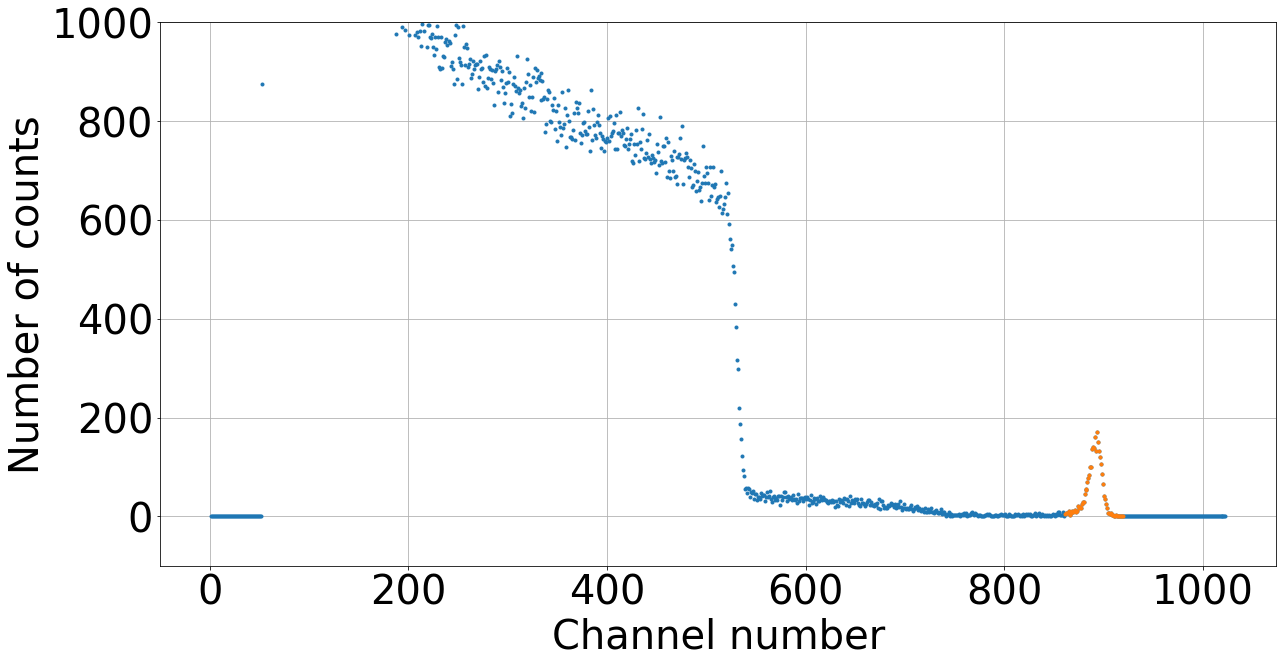

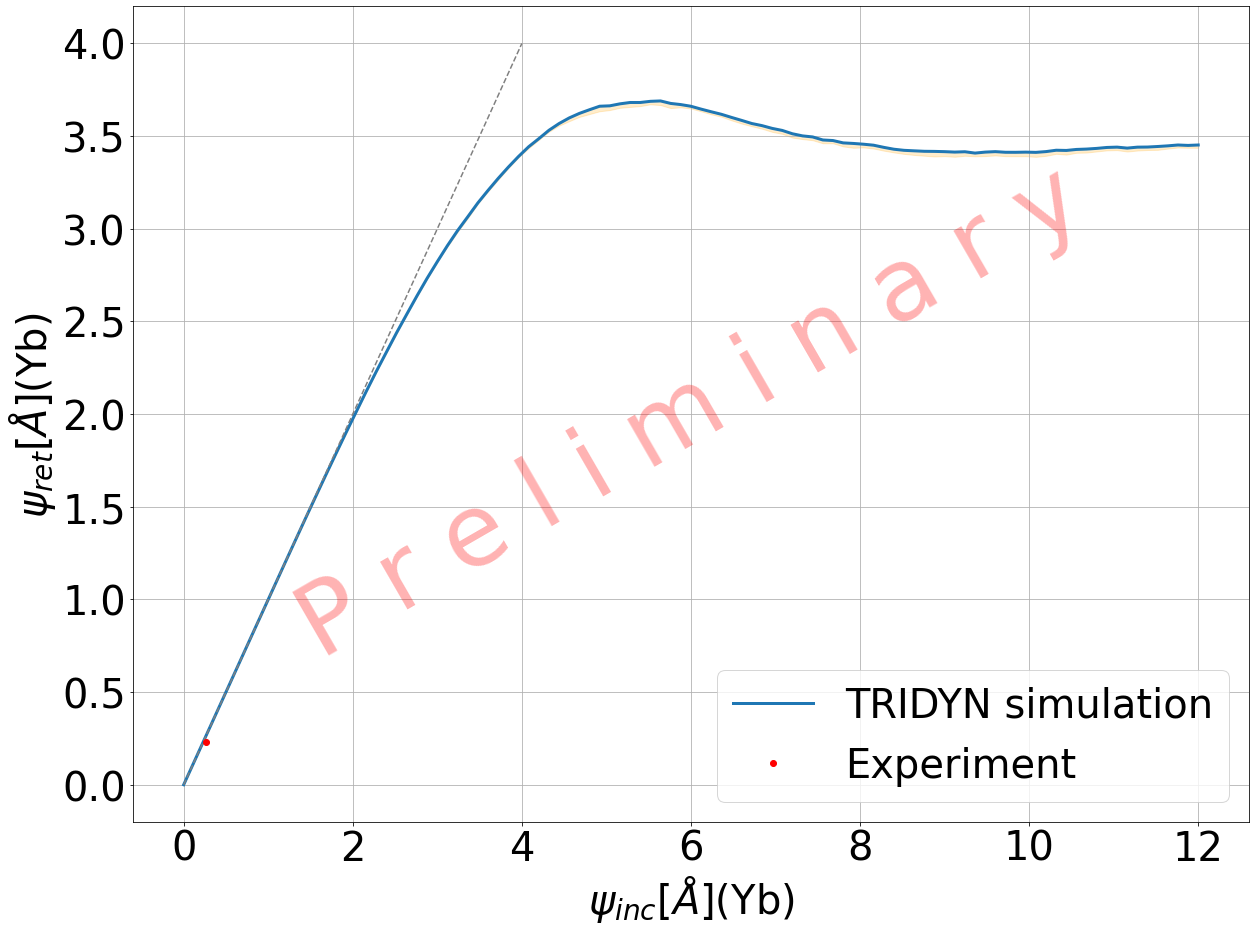

In [185]:
get_info(60, 'Al','-', '#1f77b4',['qz7931_ANR.txt'],[calinfo1],[0.261],savenaam='Alimpl.pdf',prelim=True)

For an incoming fluence = 0.261A$^{-2}$, the amount that is retained on the foil equals 0.2690874566899426A$^{-2}$.


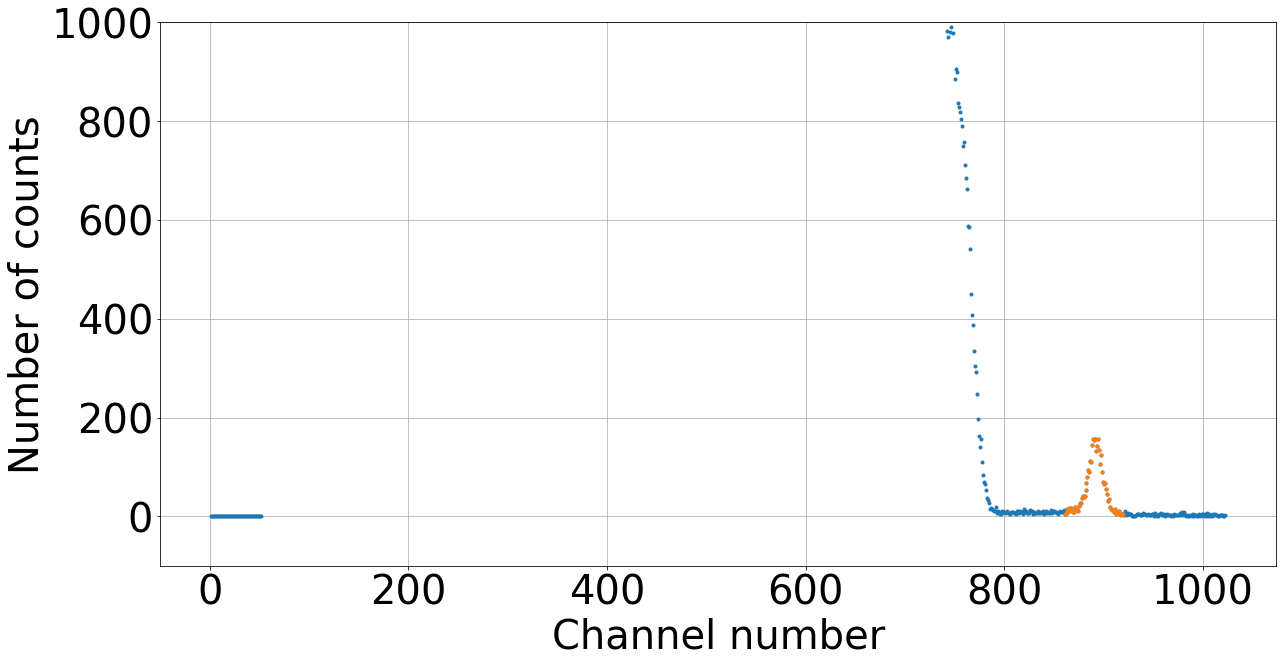

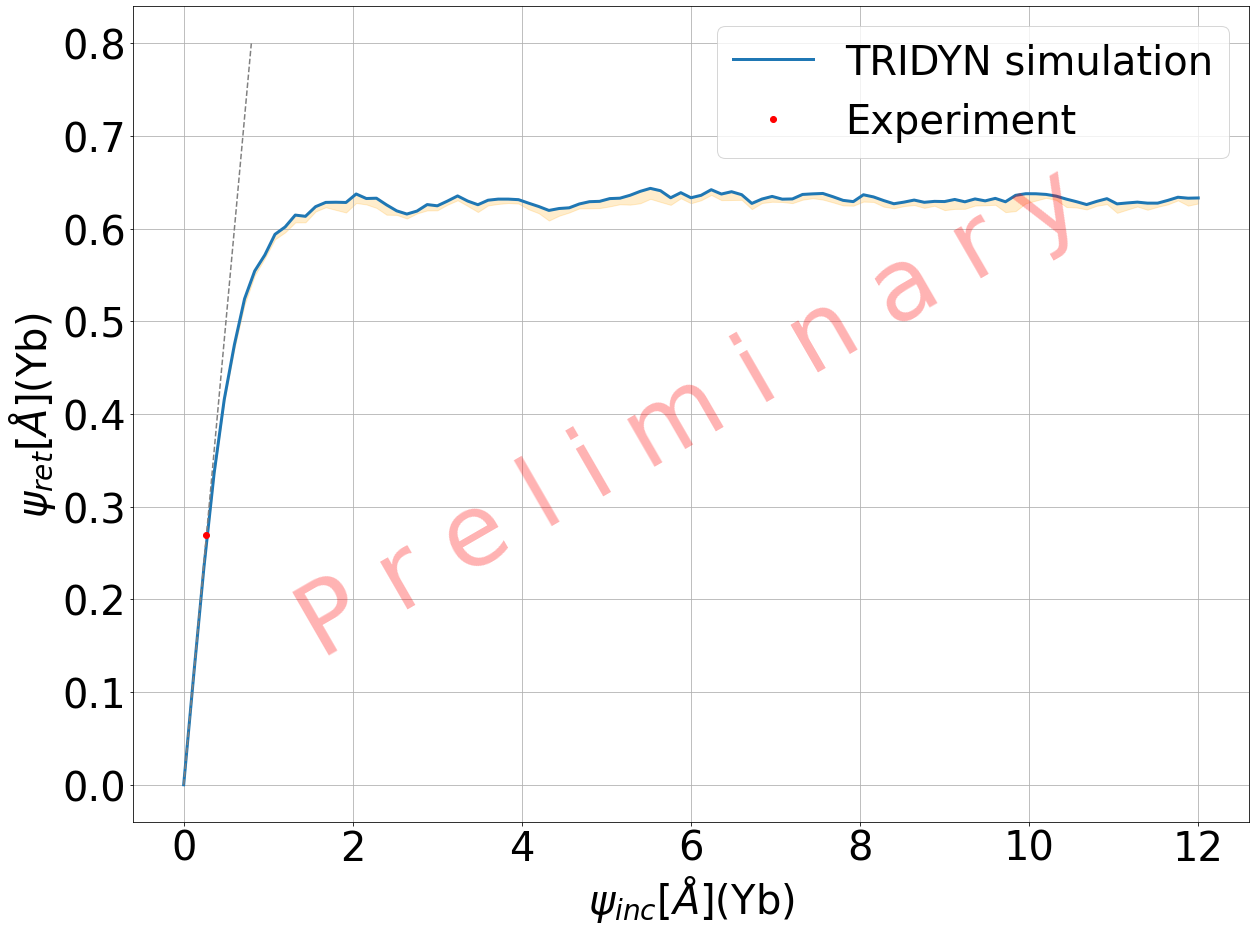

In [186]:
get_info(60, 'Zn','-', '#1f77b4',['qz7930_ANR.txt'],[calinfo1],[0.261],plotlim=0.8,savenaam='Znimpl.pdf',prelim=True)

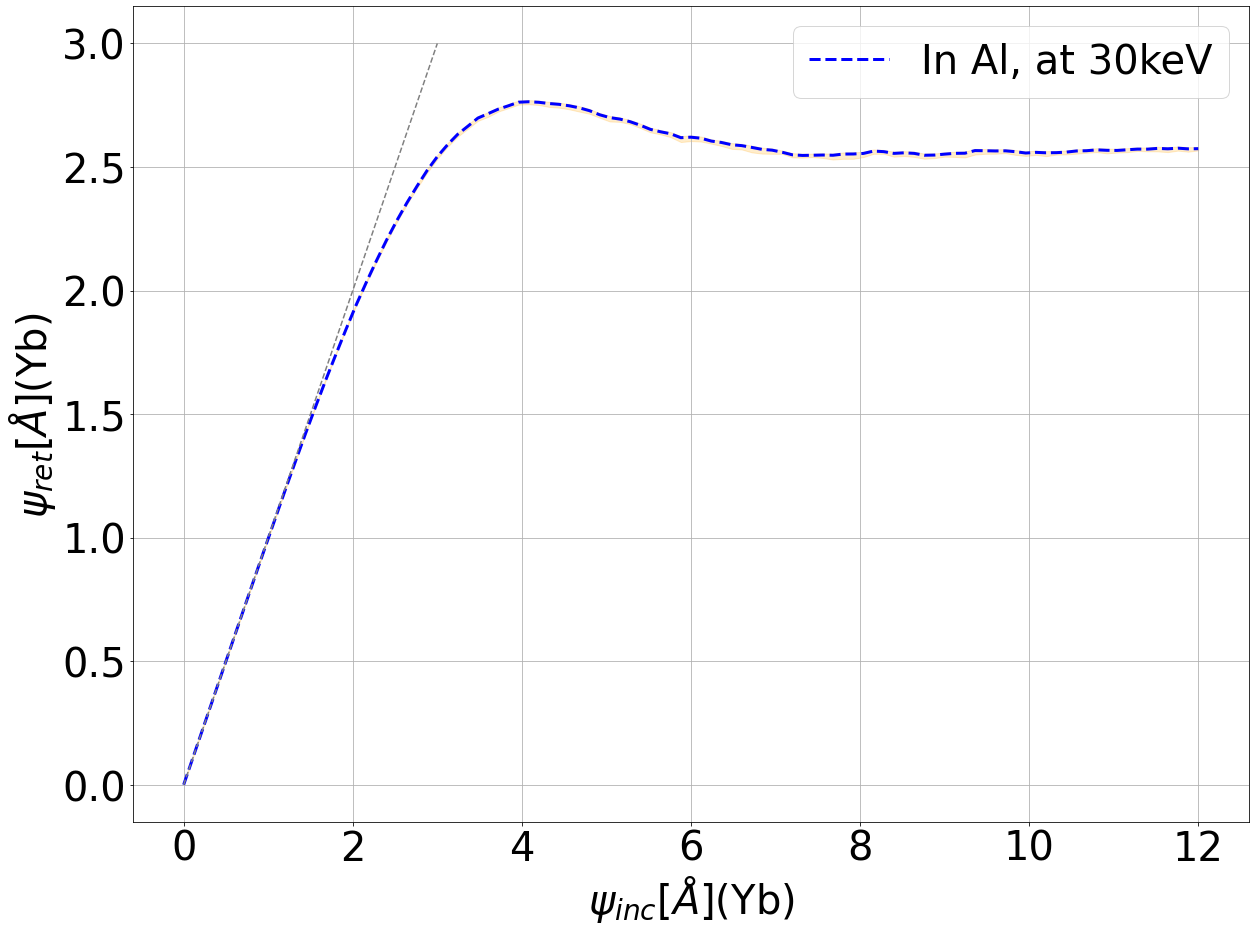

In [21]:
get_info(30, 'Al','--', 'b',['file1','file2'],[calinfo1,calinfo1,calinfo1,calinfo1,calinfo1],plotlim = 3)